In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from glob import glob
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import torchvision
import torchsummary as summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
class conv_block(nn.Module):
    def __init__(self, in_chanels, num_filters):
        super(conv_block,self).__init__()
        self.conv1 = nn.Conv2d(in_chanels, num_filters, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)
        self.relu2 = nn.ReLU()
    def forward(self,inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

In [3]:
class encoder(nn.Module):
    def __init__(self, in_chanels, num_filters):
        super(encoder,self).__init__()
        self.conv = conv_block(in_chanels, num_filters)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self,inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x,p

In [4]:
class decoder(nn.Module):
    def __init__(self, in_chanels, num_filters):
        super(decoder,self).__init__()
        self.up = nn.ConvTranspose2d(in_chanels, in_chanels//2, kernel_size=2, stride=2)
        self.conv = conv_block(in_chanels, num_filters)

    def forward(self,inputs,skip):
        x = self.up(inputs)
        # print(x.shape)
        x = torch.cat((x,skip),1)
        # print(x.shape)
        x = self.conv(x)
        return x

In [5]:
class MyUnet(nn.Module):
    def __init__(self, in_chanels, num_classes):
        super(MyUnet,self).__init__()

        self.en1 = encoder(in_chanels, 64)
        self.en2 = encoder(64, 128)
        self.en3 = encoder(128, 256)
        self.en4 = encoder(256, 512)

        self.bridge = conv_block(512, 1024)

        self.de1 = decoder(1024, 512)
        self.de2 = decoder(512, 256)
        self.de3 = decoder(256, 128)
        self.de4 = decoder(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding=0)
        
    def forward(self,inputs):
        en1, p1 = self.en1(inputs)
        # print(en1.shape)
        en2, p2 = self.en2(p1)
        # print(en2.shape)
        en3, p3 = self.en3(p2)
        # print(en3.shape)
        en4, p4 = self.en4(p3)
        # print(en4.shape)
        b = self.bridge(p4)
        # print(b.shape)
        de1 = self.de1(b,en4)
        # print(de1.shape)
        de2 = self.de2(de1,en3)
        # print(de2.shape)
        de3 = self.de3(de2,en2)
        # print(de3.shape)
        de4 = self.de4(de3,en1)
        # print(de4.shape)
        output = self.final_conv(de4)
        # print(output.shape)
        
        return output

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
num_classes = 1
in_chanels = 3
model = MyUnet(in_chanels, num_classes).to(device)
dummy_input = torch.randn(1, 3, 256, 256).to(device)
output = model(dummy_input)
print(output.shape)

torch.Size([1, 1, 256, 256])


In [8]:
output = output.squeeze(0)


In [19]:
summary.summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        conv_block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
           encoder-9  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14    

In [9]:
class UnetDataset(Dataset):
    def __init__(self,X,y, transforms = None):
        self.images_path = X
        self.masks_path = y
        self.transform = transforms
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, index):
        image = Image.open(self.images_path[index]).convert('RGB')
        mask = Image.open(self.masks_path[index]).convert('L')
        image = np.array(image).astype(np.float32)
        mask = np.array(mask).astype(np.float32)
        image = image/255.0
        mask = mask/255.0

        # print(mask.size)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [11]:
X = sorted(glob(os.path.join('datasets', 'images_split', '*')))
y = sorted(glob(os.path.join('datasets', 'masks_split', '*')))

In [12]:
val_size = 0.2
test_size = 0.125
seed = 19
is_shuffle = True

X_train,X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = val_size, 
    random_state = seed,
    shuffle = is_shuffle
)
X_train,X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size = test_size, 
    random_state = seed,
    shuffle = is_shuffle
)


In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = UnetDataset(X_train, y_train, transforms=transform)
val_dataset = UnetDataset(X_val, y_val, transforms=transform)
test_dataset = UnetDataset(X_test, y_test, transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
train_images, train_mask = next(iter(train_loader))

def show_batch(imgs,mks):
    grid = torchvision.utils.make_grid(imgs, nrow = 4, normalize = True)
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.axis('off')
    plt.show()
    grid_mks = torchvision.utils.make_grid(mks, nrow = 4, normalize = True)
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(grid_mks, (1,2,0)))
    plt.axis('off')
    plt.show()

show_batch(train_images, train_mask)

In [51]:
test_pred = torch.randint(0,2,(4,1,3,3))
test_target = torch.randint(0,2,(4,1,3,3))

In [13]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss()  

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)
model_file = "best_model.pt"
best_loss = float('inf')

patience = 20
no_improve_epochs = 0

# Hàm tính IoU
def mean_iou(preds, targets, num_classes=2):
    preds = torch.round(torch.sigmoid(preds)) 
    iou_list = []
    for c in range(num_classes):
        intersection = torch.sum((preds == c) & (targets == c))
        union = torch.sum((preds == c) | (targets == c))
        iou = intersection / (union + 1e-6)
        iou_list.append(iou)
    return torch.mean(torch.tensor(iou_list))

num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_iou = 0
    for inputs, targets in train_loader:  
        inputs, targets = inputs.cuda(), targets.cuda()  
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_iou += mean_iou(outputs, targets).item()

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)

    model.eval()
    val_loss = 0
    val_iou = 0
    with torch.no_grad():
        for inputs, targets in val_loader: 
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_iou += mean_iou(outputs, targets).item()

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), model_file)
        print(f"Model improved, saving to {model_file}")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")


Epoch [68/150], Train Loss: 0.0079, Train IoU: 0.9492, Val Loss: 0.0158, Val IoU: 0.9196
Epoch [69/150], Train Loss: 0.0071, Train IoU: 0.9533, Val Loss: 0.0166, Val IoU: 0.9100
Epoch [70/150], Train Loss: 0.0070, Train IoU: 0.9535, Val Loss: 0.0133, Val IoU: 0.9332
Epoch [71/150], Train Loss: 0.0065, Train IoU: 0.9571, Val Loss: 0.0121, Val IoU: 0.9357
Epoch [72/150], Train Loss: 0.0063, Train IoU: 0.9578, Val Loss: 0.0117, Val IoU: 0.9358
Epoch [73/150], Train Loss: 0.0065, Train IoU: 0.9569, Val Loss: 0.0111, Val IoU: 0.9389
Epoch [74/150], Train Loss: 0.0063, Train IoU: 0.9584, Val Loss: 0.0114, Val IoU: 0.9386
Epoch [75/150], Train Loss: 0.0061, Train IoU: 0.9589, Val Loss: 0.0125, Val IoU: 0.9363
Epoch [76/150], Train Loss: 0.0059, Train IoU: 0.9603, Val Loss: 0.0116, Val IoU: 0.9397
Epoch [77/150], Train Loss: 0.0060, Train IoU: 0.9599, Val Loss: 0.0114, Val IoU: 0.9403
Epoch [78/150], Train Loss: 0.0059, Train IoU: 0.9602, Val Loss: 0.0124, Val IoU: 0.9390
Epoch [79/150], Train

In [14]:
model_file = "best_model.pt"

In [15]:
model = MyUnet(in_chanels, num_classes).to(device)
model.load_state_dict(torch.load(model_file))

/tmp/ipykernel_2574404/3625595605.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


<All keys matched successfully>

In [16]:
from process.pre_process import cut_unecessary_img, resize_image, split_image, merge_images

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def visualize(input_image, target_mask, predicted_mask):

    input_image = np.transpose(input_image, (1, 2, 0))  
    
    if len(target_mask.shape) == 3:
        target_mask = target_mask.squeeze(0) 
    if len(predicted_mask.shape) == 3:
        predicted_mask = predicted_mask.squeeze(0) 

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(input_image)
    axes[0].set_title("Input Image")
    axes[0].axis('off')

    axes[1].imshow(target_mask, cmap='gray')
    axes[1].set_title("True Mask")
    axes[1].axis('off')

    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.show()


def predict_and_visualize(model, dataloader, device='cuda'):
    model.eval()  
    with torch.no_grad(): 
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
           
            outputs = torch.sigmoid(outputs)  
            predicted_mask = (outputs > 0.5).float()  

            predicted_mask = predicted_mask.cpu().numpy()
            inputs = inputs.cpu().numpy()
            
            visualize(inputs[0], targets[0].cpu().numpy(), predicted_mask[0])
# predict_and_visualize(model, val_loader, device='cuda')

In [18]:
def predict(model, image_patch, device = 'cuda'):
    model.eval()
    with torch.no_grad():
        inputs = image_patch.to(device)
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        predicted_mask = (outputs > 0.5).float()
        predicted_mask = predicted_mask.cpu().numpy()
        return predicted_mask

In [19]:
image_path = os.path.join("images","T8_10x_3d_71-1.jpg")
print(image_path)

images/T8_10x_3d_71-1.jpg


In [21]:
origin_image = Image.open(image_path).convert('RGB')
origin_image = np.array(origin_image)
print(origin_image.shape)
origin_image = cut_unecessary_img(origin_image)
origin_image = resize_image(origin_image)
test_image = origin_image.astype(np.float32)
test_image = test_image/255.0
test_image_patches = split_image(test_image)
test_image_patches = np.array(test_image_patches)
test_image_patches = torch.tensor(test_image_patches).permute(0,3,1,2).float().to(device)
test_image_patches.size()

(1536, 1024, 3)


torch.Size([24, 3, 256, 256])

In [22]:
preidct_test_mask = predict(model, test_image_patches)

In [34]:
def merge_patches_into_image(predicted_masks, original_image):
    m, n = original_image.shape[0] // 256, original_image.shape[1] // 256
    print(m, n)
    height, width = 256 * m, 256 * n
    merged_image = np.zeros((height, width), dtype=np.float32)

    # Xác định cách các patch sẽ được đặt vào ảnh lớn
    for i in range(m):
        for j in range(n):
            patch_index = i * n + j
            patch = predicted_masks[patch_index]

            start_x = i * 256
            start_y = j * 256
            
            merged_image[start_x:start_x + 256, start_y:start_y + 256] = patch

    return merged_image

6 4


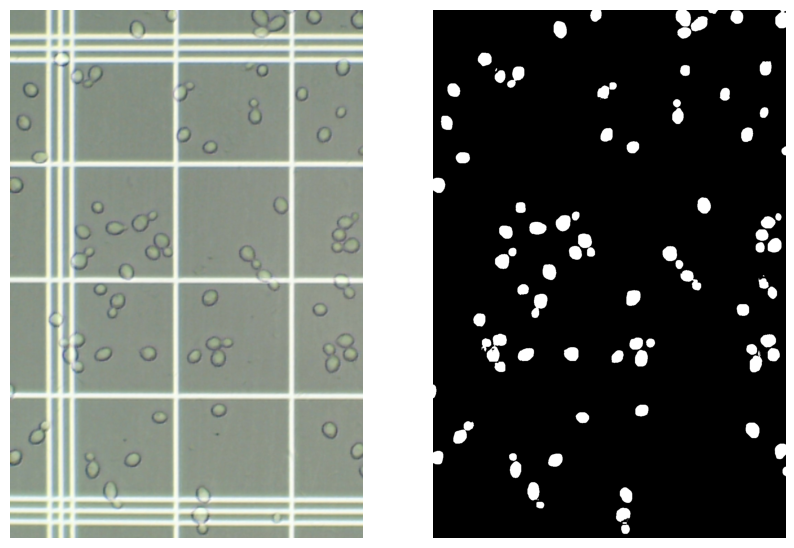

In [35]:
merged_mask = merge_patches_into_image(preidct_test_mask, test_image)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(origin_image)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(merged_mask, cmap='gray')
plt.axis('off')
plt.show()

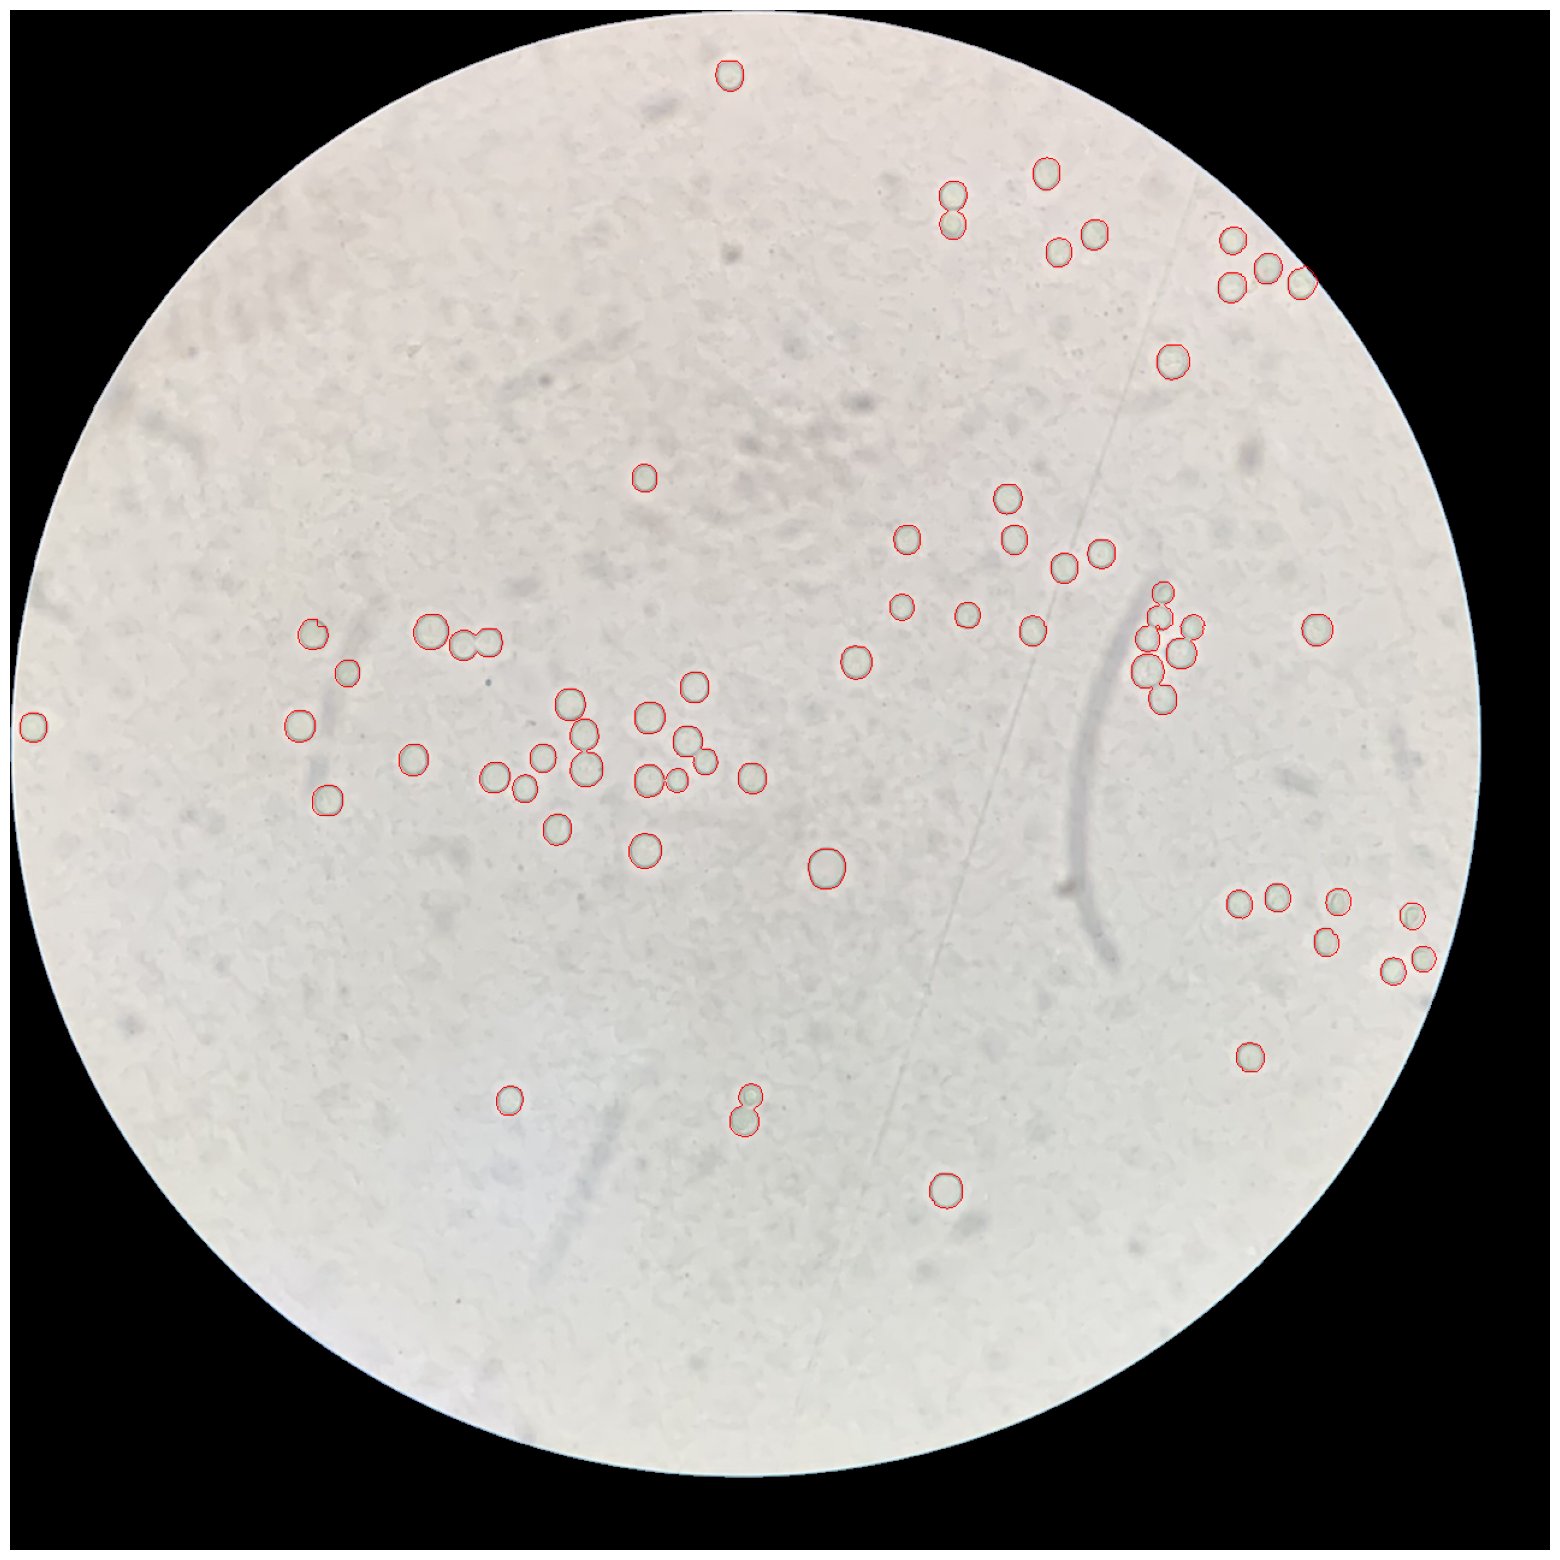

In [18]:
contours, _ = cv2.findContours((merged_mask * 255).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    cv2.drawContours(origin_image, [cnt], 0, (255, 0, 0), 1)
plt.figure(figsize=(20,20))
plt.imshow(origin_image)
plt.axis('off')
plt.show()